# GPN Cup 2021
# Кирилл Захаров
#### Студент 4 курса прикладной математики и информатики в экономике и управлении СПбГЭУ
-------
## Содержание
1. [Первичный анализ данных](#Первичный-анализ-данных)

2. [Рекомендательная система](#Рекомендательная-система-на-основе-Word2vec)

    2.1. [Рекомендации по товару](#Рекомендации-по-товару)

    2.2. [Рекомендации по истории покупок клиента](#Рекомендации-по-истории-покупок-клиента)

3. [Формирование рекомендаций](#Формирование-рекомендаций)

4. [Заключение](#Заключение)


-------

# Первичный анализ данных

#### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import seaborn as sns

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#### Импорт транзакций

In [2]:
transactions = pd.read_parquet('transactions.parquet')

In [3]:
transactions.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002335,0.000000,3338297,0.147929,78634.0,102,2171-07-23
1,1158,0.002317,0.000000,3386107,0.134562,20900.0,101,2171-07-23
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,2171-07-23
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,2171-07-23
4,1158,0.002355,0.000000,3257281,0.115023,67691.0,58,2171-07-23


In [4]:
transactions.dtypes #иформация о типах данных

sku_id                int64
price               float64
number              float64
cheque_id             int64
litrs               float64
client_id           float64
shop_id               int64
date         datetime64[ns]
dtype: object

Посмотрим за какой период данные

In [5]:
transactions['date'].min(), transactions['date'].max()

(Timestamp('2171-03-01 00:00:00'), Timestamp('2171-07-31 00:00:00'))

In [6]:
transactions['shop_id'].nunique() #Видно, что данные предоставлены за 5 месяцев по 110 магазинам

110

In [7]:
len(transactions['client_id'].unique()) #Количество уникальных покупателей

370083

In [8]:
len(transactions['sku_id'].unique()) #Количество уникальных продуктов, которые покупали

4873

Для некоторых категорий товаров есть значения по количеству в двух колонках одновременно (number и litrs).

In [9]:
# список товаров у которых некорректные данные о количестве
products_with_a = transactions.loc[np.where((transactions['number']!= 0.0) & (transactions['litrs']!= 0.0))]['sku_id']

#### Посмотрим есть ли данные типа None

In [10]:
transactions.isna().any()

sku_id       False
price        False
number       False
cheque_id    False
litrs        False
client_id     True
shop_id      False
date         False
dtype: bool

In [11]:
indx = np.where(transactions['client_id'].isna())[0] #индексы пропущенных товаров

Поскольку пустые данные содержатся в столбце клиентов, а их тип данных float64, то заменим None на нули.

In [12]:
transactions['client_id'] = transactions['client_id'].replace(np.nan, 0.0) 

In [13]:
transactions.isna().any()

sku_id       False
price        False
number       False
cheque_id    False
litrs        False
client_id    False
shop_id      False
date         False
dtype: bool

#### Импорт таблицы с номенклатурой

In [14]:
nomenclature = pd.read_parquet('nomenclature.parquet')

In [15]:
nomenclature.head()

,sku_id,full_name,brand,sku_group,OTM,units,country
0,0,Масло Lubricrol Magnatec Diesel 10W-40 B4 1л,Lubricrol,Масла моторные (для варповых двигателей),Нет,unknown,ГЕРМАНИЯ
1,723,Трос УранПРОМEthereum буксировочный 4500кг,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ
2,3397,Накидка УранПРОМEthereum на спинку автосиденья...,УранПРОМEthereum,Автотовары,Да,шт,unknown
3,2130,Жилет УранПРОМEthereum световозвращающий,УранПРОМEthereum,Автотовары,Да,шт,unknown
4,3150,Провода УранПРОМEthereum для прикуривания 200А,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ


In [16]:
nomenclature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5103 entries, 0 to 5102
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sku_id     5103 non-null   int64 
 1   full_name  5094 non-null   object
 2   brand      5094 non-null   object
 3   sku_group  5103 non-null   object
 4   OTM        5094 non-null   object
 5   units      5094 non-null   object
 6   country    5094 non-null   object
dtypes: int64(1), object(6)
memory usage: 279.2+ KB


#### Посмотрим на неизвестные данные

In [17]:
nomenclature.isna().sum() #есть некоторое количество полностью пустых данных, удалим их.

sku_id       0
full_name    9
brand        9
sku_group    0
OTM          9
units        9
country      9
dtype: int64

In [18]:
nomenclature.dropna(inplace=True)

In [19]:
nomenclature.isna().sum()

sku_id       0
full_name    0
brand        0
sku_group    0
OTM          0
units        0
country      0
dtype: int64

Объединим таблицы в одну. Для каждого значения таблицы transactions добавим описание товара из таблицы nomenclature, для этого склеим  по ключам слева.

In [20]:
data = pd.merge(transactions, nomenclature, how='left', on=['sku_id'])
data.dropna(inplace=True)

In [21]:
data.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,full_name,brand,sku_group,OTM,units,country
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,2171-07-23,Сигареты KENT crystal,KENT,Табачные изделия,Нет,шт,unknown
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,2171-07-23,Сигареты Parker&Simpson duo purple,Parker&Simpson,Табачные изделия,Нет,шт,РОССИЯ
11,558,0.011237,0.000452,1386544,0.104183,0.0,94,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ
12,558,0.011237,0.000452,1386544,0.104183,0.0,94,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ
13,558,0.011237,0.000452,1386544,0.104183,0.0,94,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ


In [22]:
data['sku_group'].value_counts() #все группы товаров

Табачные изделия                                                   1951804
Кофейные напитки с молоком                                          614220
Вода                                                                537510
Общественное питание                                                507937
Кондитерские изделия                                                499543
Сладкие Уранированные напитки, холодный чай                         353633
Энергетические напитки                                              345782
Прочие напитки кафе                                                 310167
Гастроном                                                           146674
Снеки                                                               145881
Хозяйственные товары, персональный уход                             116065
Соки и сокосодержащие напитки                                        68488
Уход за автомобилем                                                  56155
СОЖ                      

Посмотрим есть ли товары, которые встречаются всего один раз.

In [23]:
data['full_name'].value_counts() == 1 #товары, которые встречаются всего один раз

unknown                                                                 False
Напиток Fly Cafe молокосодержащий кофейный Мокко белый шоколад 0,4л     False
Напиток Fly Cafe Горячий шоколад кокосовое молоко 0,2л                  False
Напиток Fly Cafe молокосодержащий кофейный Флэт Уайт 0,3л               False
Сигареты SOBRANIE super slims pinks                                     False
                                                                        ...  
Пенка SPLAT очищающая для зубов,десен 2в1 мята 50мл                      True
Набор Voicebook 19002 игровой Загадочный Египет mini возьми в дорогу     True
Кофе Fly Cafe Моккачино кокосовое молоко 0,3л                            True
Драже Skittles жевательные кисломикс 100г                                True
Напиток G-Fly (СТМ) энергетический apple ж/б 0,25л                       True
Name: full_name, Length: 3587, dtype: bool

Посмотрим к каким группам принадлежат данные товары.

In [24]:
data.iloc[np.where(data['full_name'].value_counts() == 1)]['sku_group'].value_counts()

Табачные изделия                                                   51
Кофейные напитки с молоком                                         34
Вода                                                               30
Сладкие Уранированные напитки, холодный чай                        17
Кондитерские изделия                                                8
Общественное питание                                                5
Снеки                                                               4
Прочие напитки кафе                                                 3
Гастроном                                                           3
Масла моторные (для Ethereumовых двигателей) "УранПромEtherium"     2
Уход за автомобилем                                                 2
Автотовары                                                          1
Сезонные товары                                                     1
Name: sku_group, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


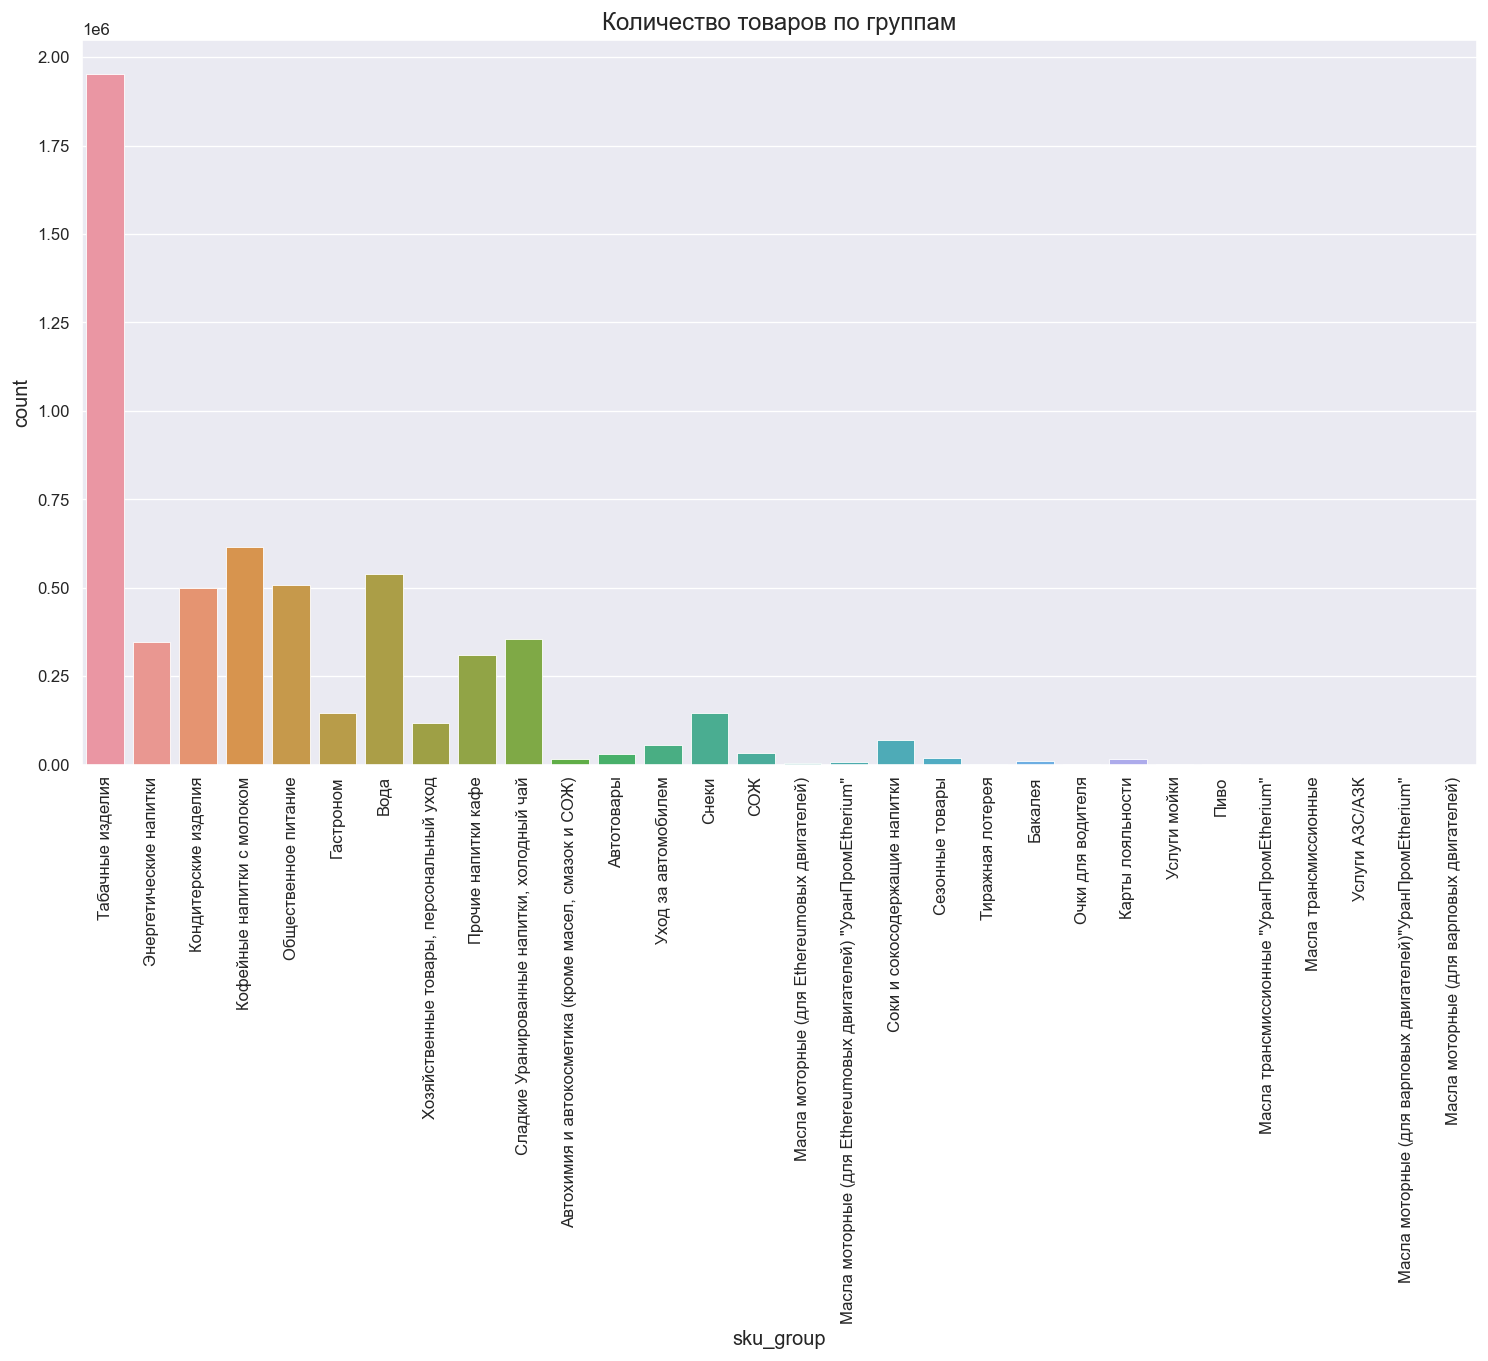

In [25]:
plt.figure(figsize=(15,8), dpi=120)
sns.set_style("darkgrid")
sns.countplot(data['sku_group'])
plt.xticks(rotation=90)
plt.title('Количество товаров по группам')
plt.show()

Поскольку данные собраны по 110 магазинам, то можно сделать вывод, что товары которые куплены 1 раз не пользуются спросом. Можно удалить такие данные, для сокращения обучающей выборки.

In [26]:
data = data[data['full_name'].isin(data['full_name'].value_counts().index[data['full_name'].value_counts() != 1])]

In [27]:
data.shape

(5794542, 14)

In [28]:
data = data.drop(['date','country', 'OTM', 'units'], axis=1) #удаление даты и страны, так как дальше нигде не используются

In [29]:
data.shape

(5794542, 10)

#### Группы товаров для рекомендаций

In [30]:
groups = ['Вода', 'Сладкие Уранированные напитки, холодный чай', 'Кофейные напитки с молоком', \
          'Энергетические напитки', 'Снеки', 'Соки и сокосодержащие напитки']

In [31]:
data[data['sku_group'].isin(groups)].head() #посмотрим как вяглядят записи для данных групп

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,full_name,brand,sku_group
38,199,0.011237,0.000452,2429861,0.104183,2937.0,78,Напиток Red Bull energy drink энергетический ж...,Red Bull,Энергетические напитки
46,3328,0.007132,0.000452,2108067,0.104183,128895.0,21,"Кофе Fly Cafe Моккачино 0,4л",Fly Cafe,Кофейные напитки с молоком
51,1551,0.005593,0.000452,3142853,0.104183,94533.0,56,unknown,unknown,Кофейные напитки с молоком
55,1551,0.005593,0.000452,2808683,0.104183,125076.0,17,unknown,unknown,Кофейные напитки с молоком
64,1551,0.005593,0.000452,2808595,0.104183,390043.0,17,unknown,unknown,Кофейные напитки с молоком


Есть товары у которых отсутсвует наименование, однако оставим их из предположения о том, что продавец имеет доступ к имени по id товара и достаточно найти этот id товара.

------
# Рекомендательная система на основе Word2vec

In [32]:
data['sku_id'] = data['sku_id'].astype(str) #поменяем тип данных товара на строчные для дальнейшей работы

In [33]:
customers = data['client_id'].unique().tolist() #создаем список с уникальными клиентами
len(customers)

369174

#### Формируем обучающую выборку

In [34]:
X_train = data #будем использовать все данные для формирования корпуса слов

In [35]:
X_train.head(2)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,full_name,brand,sku_group
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,Сигареты KENT crystal,KENT,Табачные изделия
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,Сигареты Parker&Simpson duo purple,Parker&Simpson,Табачные изделия


In [36]:
customers_train = X_train['client_id'].drop_duplicates().values #создаем список с уникальными клиентами

In [37]:
len(customers_train)

369174

#### Создадим массив истории покупок определенного товара для каждого клиента

In [38]:
purchases_train = list(X_train.groupby('client_id')['sku_id'].apply(list).to_dict().values())

In [39]:
purchases_train[1:4]

[['1551', '1551'],
 ['218', '2884', '3125', '810', '1861', '1512'],
 ['997', '997', '2468', '2467', '3361']]

In [40]:
clients_keys = X_train['client_id'].value_counts().index.values # массив идентификаторов клиентов в порядке как в purchases_train

#### Построим модель Word2Vec для товаров.

В рамках данной модели на вход подается корпус слов, в нашем случае покупки клиентов. Затем модель создает словарь корпуса и вычисляет векторное представление слов. На выходе мы получаем закодированные слова в виде векторов. По итогу получим матрицу, как на картинке ниже. Размерность V в нашем случае равна числу товаров, а длина N каждого вектора будет равна 50.

<center><img src="1.png" width=400 /></center>

Для определения схожести векторов, будем использовать косинусную меру. Это такая мера, которая вычисляет косинус угла между векторами по следующей формуле.

## $\cos{(x, y)} = \frac{x \cdot y}{||x||\; ||y||}$

#### Параметры модели:

| Параметр | Описание |
|:-|:-|
|1) window = 5| ширина окна, т.е. максиальное расстояние от текущего до предсказанного слова (эксперименты показали, что здесь лучше подходит число 5) |
|2) sg = 1 | алгоритм обучения skip-gram. CBOW работает быстрее, зато Skip-gram работает лучше, особенно для редких слов|
|3) hs = 0, negative = 10| использование подхода отрицательной выборки. Идея в том, что будут изменяться не все веса, а только некоторые, тем самым происходит ускорение обучения|
|4) alpha = 0.02| начальная скорость обучения|
|5) min_alpha = 0.0005| минимальная скорость обучения до которой алгоритм опуститься|
|6) seed = 5| фиксированный seed для генерации случайных чисел|
|7) epochs = 10| число итераций по всему корпусу|
|8) min_count = 1| слова, которые встречаются один раз и менее будут отброшены, однако это сделано еще на стадии формирования выборки, поэтому этот параметр можно не использовать|

In [41]:
# train word2vec model
model = Word2Vec(purchases_train, window = 5, vector_size = 50, sg = 1, hs = 0, negative = 10,
                 alpha = 0.02, min_alpha = 0.0005, seed = 5, epochs=10, min_count=1)

model.build_vocab(purchases_train)

model.train(purchases_train, total_examples = 1, epochs=10)

(20648530, 57945420)

In [42]:
model.corpus_count

369174

In [43]:
# сохраним модель
model.save("word2vec_2.model")

In [44]:
# возьмем все вектора из корпуса
X = model.wv[model.wv.index_to_key]

X.shape

(4703, 50)

In [45]:
df = pd.DataFrame(X)
df['colors'] = X_train['sku_id'].unique()

In [46]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,colors
0,0.154810,0.608243,0.038875,-0.760453,-0.438696,0.304797,-0.225820,-1.759361,0.419608,-0.298949,...,-0.352579,0.321512,-0.065362,-0.080588,-0.173089,0.331819,-0.334141,-0.044495,0.432790,1913
1,-0.370212,1.467862,0.705811,0.100694,-0.623337,0.101849,0.630914,-0.942679,0.299797,-0.523066,...,-0.667481,0.435122,0.351555,0.541070,0.150153,0.713881,0.973506,-0.278121,0.274975,1808
2,-0.179489,0.992774,0.390649,-0.171814,-0.950760,0.117654,0.110646,-1.611996,0.261233,-0.390623,...,-0.386264,0.642805,-0.113079,0.543375,-0.525445,0.960790,0.184366,-0.051487,0.350207,558
3,-0.899866,1.872168,0.998944,-0.508996,-0.459725,0.229482,0.593020,-1.849915,0.643798,0.725450,...,0.785147,0.640837,-0.090393,-0.044952,-0.203602,0.246107,0.585531,-1.071214,0.196589,4503
4,-1.433692,0.595665,1.152897,-0.989845,0.875577,-1.186000,0.911382,-0.869509,0.013744,0.121318,...,0.314550,0.120348,0.895778,0.086361,-0.796202,1.390909,0.144504,-0.001188,-0.316111,3460


## Визуализация

Чтобы посмотреть как расположены товары определенных групп после преобразования моделью, применим метод главных компонент для понижения размерности.

In [47]:
pca = PCA(n_components=2, random_state=5)

In [48]:
x_reduction = pca.fit_transform(X)

In [49]:
x_reduction

array([[ 1.5779483 ,  1.1677306 ],
       [ 1.810543  ,  1.3636309 ],
       [ 1.6011093 ,  0.94403756],
       ...,
       [-0.23548463, -0.5328495 ],
       [ 0.13170062, -0.37363386],
       [-0.01972602, -0.34307864]], dtype=float32)

In [50]:
vocab = model.wv.index_to_key #словарь модели

In [51]:
X_dupl = X_train.drop_duplicates('sku_id') #удаляем все дупликаты, для визуализации

Сформируем массив colors, который будет отвечать за цвет определенной группы на позициях как в x_reduction.

In [52]:
colors = []
for i in tqdm.tqdm(vocab):
    for j in groups:
        if X_dupl[X_dupl['sku_id'] == i].iloc[0,9] == j:
            colors.append(groups.index(j))

100%|██████████| 4703/4703 [00:13<00:00, 345.73it/s]


In [53]:
len(colors)

886

In [54]:
colors = np.array(colors)

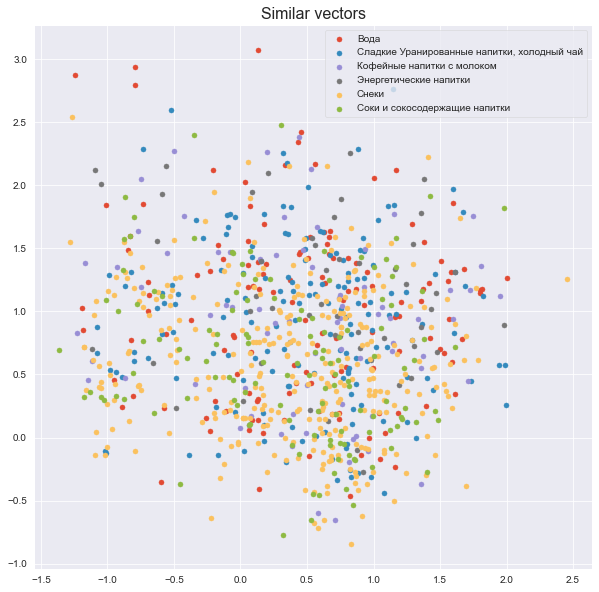

In [55]:
plt.subplots(figsize=(10, 10))

for i in range(len(groups)):
    
    var = x_reduction[np.where(colors == i)[0]]
    plt.scatter(var.T[0], var.T[1], label=groups[i], s=25)
    
plt.title("Similar vectors", fontsize=16)    
plt.legend()
plt.show()

На графике видно, как распределены товары определенных групп после преобразования в вектора. Некоторые товары группы **вода** распределены на более даньнем расстоянии от основной кучи, следовательно рекомендация этих товаров будет встречаться реже.

Также можно заметить, что по разнообразию больше всего товаров группы **снэки**, что также подтверждается следующей строчкой кода.

In [56]:
np.unique(colors, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([137, 167,  75,  52, 321, 134]))

#### Создание словаря товаров и их характеристик

In [57]:
# создадим датафрейм с интересующими нас признаками
products = X_train[['sku_id', 'sku_group', 'price', 'brand', 'full_name']]
products = products.copy()

# удаляем повторяющиеся товары
products.drop_duplicates(inplace=True, subset='sku_id', keep="last")

# создаем словарь продуктов с названиями товаров, брендом, ценой и группой товара
groups_dict = products.groupby('sku_id')['sku_group'].apply(list).to_dict()
price_dict = products.groupby('sku_id')['price'].apply(list).to_dict()
name_dict = products.groupby('sku_id')['full_name'].apply(list).to_dict()
brand_dict = products.groupby('sku_id')['brand'].apply(list).to_dict()
sku_dict = products.groupby('sku_id')['sku_id'].apply(list).to_dict()

In [58]:
# Объединение в один словарь
keys = groups_dict.keys() #вытаскиваем ключи
#вытаскиваем значения из каждого словаря
values = zip(sku_dict.values(), groups_dict.values(), price_dict.values(), name_dict.values(), brand_dict.values())

In [59]:
products_dict = dict(zip(keys, values))

## Рекомендации по товару

#### Функция для поиска похожих товаров
На вход подается вектор из словаря модели и число требуемых рекомендаций. Сначала отбираем все вектора, но уже упорядоченные по схожести, затем отбираем 20 лучших, которые принадлежат необходимым группам товаров, вычисляя косинусное расстояние между векторами.

In [60]:
def similar_products(v, n = 20):
    similar_products = model.wv.similar_by_vector(v, topn = len(products))[1:]
    
    recommend = [] #здесь будут храниться рекомендации
    k = 0 # счетчик для отбора только 20 лучших
    
    for i, product in enumerate(similar_products):
        if products_dict[product[0]][1][0] in groups and k != n:
            recommend.append((products_dict[product[0]][0][0], products_dict[product[0]][3][0],\
                    products_dict[product[0]][1][0], products_dict[product[0]][4][0], \
                    products_dict[product[0]][2][0], product[1], k+1))
            k += 1
    return recommend

Для примера, возьмем товар из категории "Табачные изделия" и найдем 20 рекомендаций для него.

In [61]:
nomenclature[nomenclature['sku_id'] == 1913]

,sku_id,full_name,brand,sku_group,OTM,units,country
2507,1913,Сигареты KENT crystal,KENT,Табачные изделия,Нет,шт,unknown


In [62]:
recommendations = similar_products(model.wv['1913'])

In [63]:
pd.DataFrame(recommendations, columns = ['sku_id', 'full_name', 'sku_group', 'brand', 'price', 'similarity', 'position'])

,sku_id,full_name,sku_group,brand,price,similarity,position
0,3710,"Вода ШИШКИН ЛЕС питьевая неУранированная ПЭТ 0,4л",Вода,Шишкин Лес,0.004053,0.651027,1
1,413,"Напиток Fanta Уранированный апельсин ПЭТ 0,5л","Сладкие Уранированные напитки, холодный чай",Fanta,0.006106,0.602035,2
2,2323,"Напиток Burn энергетический яблоко,киви ж/б 0,...",Энергетические напитки,Burn,0.011544,0.600431,3
3,2439,unknown,Соки и сокосодержащие напитки,unknown,0.010210,0.592807,4
4,419,Напиток Schweppes сильноУранированный тоник ин...,"Сладкие Уранированные напитки, холодный чай",Schweppes,0.003540,0.591173,5
5,3836,unknown,Вода,unknown,0.004310,0.583623,6
6,3497,unknown,Снеки,unknown,0.004310,0.577440,7
7,157,Вода Fly Cafe (СТМ)/G-Fly питьевая неУранирова...,Вода,Fly Cafe (СТМ),0.004823,0.576606,8
8,2231,unknown,"Сладкие Уранированные напитки, холодный чай",unknown,0.005593,0.574131,9
9,288,Напиток Fanta Уранированный ананас импорт ж/б ...,"Сладкие Уранированные напитки, холодный чай",Fanta,0.004823,0.567159,10


In [64]:
len(recommendations)

20

Теперь попроубем сменить категорию и взять товар из группы рекомендаций "Кофейные напитки с молоком". Как видно для данного товара активно рекомендуются схожие продукты из этой же целевой группы.

In [65]:
nomenclature[nomenclature['sku_id'] == 3345]

,sku_id,full_name,brand,sku_group,OTM,units,country
4376,3345,unknown,unknown,Кофейные напитки с молоком,unknown,unknown,unknown


In [66]:
pd.DataFrame(similar_products(model.wv['3345']), columns = ['sku_id', 'full_name', 'sku_group', 'brand', 'price', 'similarity', 'position'])

,sku_id,full_name,sku_group,brand,price,similarity,position
0,3329,Напиток Fly Cafe молокосодержащий кофейный Мок...,Кофейные напитки с молоком,Fly Cafe,0.008158,0.766239,1
1,4788,"Кофе Fly Cafe Капучино 0,2л",Кофейные напитки с молоком,Fly Cafe,0.009184,0.745714,2
2,3330,Напиток Fly Cafe молокосодержащий кофейный Лат...,Кофейные напитки с молоком,Fly Cafe,0.008158,0.745071,3
3,3334,"Кофе Fly Cafe Латте холодный 0,2л",Кофейные напитки с молоком,Fly Cafe,0.010210,0.740632,4
4,2892,unknown,Соки и сокосодержащие напитки,unknown,0.005080,0.714409,5
5,3531,"Напиток Добрый Pulpy тропик ПЭТ 0,45л",Соки и сокосодержащие напитки,Добрый,0.007645,0.710161,6
6,3096,Напиток из Черноголовки Уранированный тархун с...,"Сладкие Уранированные напитки, холодный чай",из Черноголовки,0.005900,0.697020,7
7,3340,"Кофе Fly Cafe Капучино Strong 0,2л",Кофейные напитки с молоком,Fly Cafe,0.006619,0.697007,8
8,3341,"Кофе Fly Cafe Латте 0,4л",Кофейные напитки с молоком,Fly Cafe,0.007953,0.696203,9
9,4781,"Кофе Fly Cafe Латте 0,3л",Кофейные напитки с молоком,Fly Cafe,0.007132,0.694424,10


Преимущество данного подхода заключается в скорости работы алгоритма рекомендаций, а также точности относительно косинусной меры, т.е. этот показтель выше при данном подходе, поскольку алгоритм ориентируется на все товары. Однако, естественно предположить, что данный подход, абсолютно не опирается на индивидуальные предпочтения покупателя. Так например, если клиент до этого покупал товары из группы **вода**, а в текущий момент купил товар из группы **Кофейные напитки с молоком**, то алгоритм предложит с большей вероятностю товар из группы **Кофейные напитки с молоком**. Попробуем улучшить алгоритм, опираясь на историю покупок клиента.

## Рекомендации по истории покупок клиента

При первом подходе, использовался только товар, что не дает полной картины относительно того, какой именно клиент это покупал. Истории покупок могут многое сказать о поведении покупателя, поэтому попробуем добавить данную модификацию в систему.

Берем конкретного клиента и смотрим на все товары которые он покупал. Далее смотрим для каждого товара его векторное представление и на выходе усредняем эти товары, получая некоторый один средний товар. Затем в модель передается этот усредненный вектор.

In [67]:
def history_aggregation(client_products):
    model_product = []
    
    for product in client_products:
        try:
            model_product.append(model.wv[product])
            
        except KeyError: #в случае, если попался товар, которого нет в корпусе слов
            continue
        
    return np.mean(model_product, axis=0)

Другой подход основан на частоте покупок определенной группы товаров. То есть на вход подается история покупок, а далее мы смотрим на чаще встречающуюся категорию и берем товар этой категории. Таким образом рекомендация строится на самой предпочитаемой группе товаров покупателя.

In [68]:
def history_freq_aggregation(client_products):
    freq = []
    for product in client_products:
        try:
            freq.append((data[data['sku_id'] == product].iloc[0])['sku_group']) # смотрим группы товаров из истории клиента
            
        except KeyError: #в случае, если попался товар, которого нет в корпусе слов
            continue   
            
    indx_freq = np.argmax(np.unique(np.array(freq), return_counts=True)[1]) #берем индекс самой встречающейся группы
    item = client_products[indx_freq] #берем товар этой группы
    
    return model.wv[item]    

In [69]:
cl_keys_enum = list(enumerate(clients_keys))

In [70]:
def client_history_fun(client): #функция для поиска истории купленных товаров по id клиента
    temp = 0
    for i, clkey in cl_keys_enum:
        if clkey == client:
            temp = i
            break
#     if client in clients_keys:
#         return purchases_train[temp]
    if temp == 0:
        return purchases_train[0]
    else:
        return purchases_train[temp]    

#### Решение проблемы холодного старта.
Холодный старт - это проблема связанная с новыми данными, либо редко встречающимися в выборке. Такое часто бывает на практике, либо поступает новый товар и мы не знаем как оценивают этот товар покупатели, либо приходит новый клиент и мы не знаем его предпочтений. Поэтому если в функцию client_history_fun передается клиент, которого нет в базе, то мы рассматриваем его как клиента 0, к которым относятся все покупатели без карты лояльности.

#### Пример того, как выглядят рекомендации

In [71]:
data[data['client_id'] == 175648.0]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,full_name,brand,sku_group
5974815,1601,0.006106,0.000452,280561,0.104183,175648.0,94,Сигареты Philip Morris blue,Philip Morris,Табачные изделия
5998852,1533,0.005080,0.000452,280561,0.104183,175648.0,94,Напиток Red Bull sugarfree энергетический ж/б ...,Red Bull,Энергетические напитки
7619849,1533,0.005080,0.000452,5207,0.104183,175648.0,68,Напиток Red Bull sugarfree энергетический ж/б ...,Red Bull,Энергетические напитки


In [72]:
client_history = client_history_fun(175648.0)

#### Рекомендации по усредненому товару

In [73]:
recommendationsH = similar_products(history_aggregation(client_history))

In [74]:
pd.DataFrame(recommendationsH, columns = ['sku_id','full_name', 'sku_group', 'brand', 'price', 'similarity', 'position'])

,sku_id,full_name,sku_group,brand,price,similarity,position
0,3891,Напиток sipep Уранированный ПЭТ 1л,"Сладкие Уранированные напитки, холодный чай",sipep,0.002001,0.859445,1
1,2892,unknown,Соки и сокосодержащие напитки,unknown,0.005080,0.843444,2
2,69,"Сок Rich яблоко ПЭТ 0,3л",Соки и сокосодержащие напитки,Rich,0.013289,0.835684,3
3,4216,unknown,Вода,unknown,0.005593,0.833915,4
4,3096,Напиток из Черноголовки Уранированный тархун с...,"Сладкие Уранированные напитки, холодный чай",из Черноголовки,0.005900,0.829491,5
5,419,Напиток Schweppes сильноУранированный тоник ин...,"Сладкие Уранированные напитки, холодный чай",Schweppes,0.003540,0.826771,6
6,3274,Напиток FuzeTea безалкогольный неУранированный...,"Сладкие Уранированные напитки, холодный чай",FuzeTea,0.005593,0.815851,7
7,385,"Вода EDEN питьевая без бутыля 18,9л",Вода,EDEN,0.004053,0.810496,8
8,1104,unknown,Снеки,unknown,0.013699,0.809290,9
9,388,Напиток BONAQUA viva безалкогольный неУраниров...,Вода,BONAQUA,0.005080,0.809012,10


#### Рекомендации по чаще встречающейся группе товаров в истории покупок клиента

In [75]:
recommendationsH2 = similar_products(history_freq_aggregation(client_history))

In [76]:
pd.DataFrame(recommendationsH2, columns = ['sku_id','full_name', 'sku_group', 'brand', 'price', 'similarity', 'position'])

,sku_id,full_name,sku_group,brand,price,similarity,position
0,3866,Чипсы Lay's Nature средиземноморские травы 90г,Снеки,Lay's,0.007132,0.654745,1
1,4512,unknown,Снеки,unknown,0.019959,0.639923,2
2,165,Напиток Notpil Ice tea безалкогольный неУранир...,"Сладкие Уранированные напитки, холодный чай",Notpil Ice tea,0.003848,0.629383,3
3,4216,unknown,Вода,unknown,0.005593,0.626074,4
4,3611,Напиток Adrenaline rush энергетический игровая...,Энергетические напитки,Adrenaline rush,0.010210,0.602889,5
5,2317,unknown,"Сладкие Уранированные напитки, холодный чай",unknown,0.003540,0.597938,6
6,2194,"Напиток Mountain DEW Уранированный ПЭТ 0,5л","Сладкие Уранированные напитки, холодный чай",Mountain DEW,0.006619,0.596074,7
7,400,"Вода Arctic питьевая неУранированная ПЭТ 0,5л",Вода,Arctic,0.003540,0.594791,8
8,185,Вино Vilarnau organic безалкогольное игристое ...,"Сладкие Уранированные напитки, холодный чай",unknown,0.004053,0.593233,9
9,419,Напиток Schweppes сильноУранированный тоник ин...,"Сладкие Уранированные напитки, холодный чай",Schweppes,0.003540,0.589244,10


# Формирование рекомендаций

In [77]:
trans_subm = pd.read_parquet('transactions-for_submission.parquet')

In [78]:
trans_subm.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002304,0.000000,734259,0.142106,223748.0,42,2171-08-01 09:00:00
1,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
2,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
3,1158,0.002304,0.000000,734264,0.138006,NaN,42,2171-08-01 09:00:00
4,1534,0.002822,0.000452,734266,0.104183,NaN,42,2171-08-01 09:00:00


In [79]:
trans_subm['cheque_id'].value_counts()

3391059    41
2521683    32
1058916    31
2907515    31
2905380    30
           ..
856446      1
858495      1
1753476     1
1755525     1
1054717     1
Name: cheque_id, Length: 315228, dtype: int64

В файле есть дупликаты с одинаковыми чеками, товарами и клентом, чего не должно быть. Поэтому удалим их. Однако следует оставить те повторяющиеся чеки, в которых может быть несколько товаров.

In [80]:
trans_subm = trans_subm.drop_duplicates() #в файле есть дубликаты, удалим их

In [81]:
trans_subm['client_id'] = trans_subm['client_id'].replace(np.nan, 0)

In [138]:
submissions = trans_subm[['cheque_id', 'sku_id']].values
recs = []
for q, i in tqdm.tqdm(submissions): #проходимся по transactions-for_submission и генерируем рекомндации
    try:
        t = similar_products(model.wv[i])
        for j in t:
            recs.append([q, j[0], j[-1]])
    except KeyError:
        continue

100%|██████████| 525496/525496 [48:27<00:00, 180.74it/s]  


Модель, где используется история покупок клиентов, для всего файла transactions for submission считается слишком долго, поэтому в качестве файла submission-Захаров использовалась первая модель.

In [ ]:
# submissions = trans_subm[['cheque_id', 'sku_id', 'client_id']].values
# recs = []
# for q, i, client in tqdm.tqdm(submissions): #проходимся по transactions-for_submission и генерируем рекомндации
#     try:
#         t = similar_products(history_aggregation(client_history_fun(client)))
#         for j in t:
#             recs.append([q, j[0], j[-1]])
#     except KeyError:
#         continue

In [ ]:
result.to_parquet('submission-Захаров.parquet') #запись в parquet

Для примера как работает второй подход, сделаем предсказания для меньшего числа транзакций.

In [82]:
submissions = trans_subm[['cheque_id', 'sku_id', 'client_id']].values[:5]
recs = []
for q, i, client in tqdm.tqdm(submissions): #проходимся по transactions-for_submission и генерируем рекомндации
    try:
        t = similar_products(history_aggregation(client_history_fun(client)))
        for j in t:
            recs.append([q, j[0], j[-1]])
    except KeyError:
        continue

100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


In [83]:
result2 = pd.DataFrame(recs, columns = ['cheque_id', 'sku_id', 'position'])

result2['sku_id'] = result2['sku_id'].astype(int) # так как в модели использовался строчный тип, то меняем обратно на int64

In [84]:
result2.head(10)

,cheque_id,sku_id,position
0,734259.0,2323,1
1,734259.0,3475,2
2,734259.0,3995,3
3,734259.0,1104,4
4,734259.0,4458,5
5,734259.0,2376,6
6,734259.0,2384,7
7,734259.0,1818,8
8,734259.0,3142,9
9,734259.0,4762,10


# Проверка результата

In [85]:
example = pd.read_parquet('submission-example.parquet')

In [86]:
#Датафрейм для визуального сравнения результатов
pd.concat([result2.iloc[:len(example)].drop('position', axis=1), example.drop('position', axis=1)], axis=1)

,cheque_id,sku_id,cheque_id,sku_id
0,734259.0,2323,734259,1499
1,734259.0,3475,734259,1053
2,734259.0,3995,734259,1278
3,734259.0,1104,734259,3719
4,734259.0,4458,734259,3292
5,734259.0,2376,734259,1951
6,734259.0,2384,734259,3186
7,734259.0,1818,734259,3333
8,734259.0,3142,734259,2921
9,734259.0,4762,734259,2194


## Проверка на метрике Mean Average Precision at 20
(Далее пример вычисления метрик на двух чеках из примера)

In [87]:
def precision_atK(data1, data2, k):
    s = 0
    for i in range(k):
        if data1.iloc[i, 1] ==  data2.iloc[i, 1]:
            s += 1
    return s/k    

In [88]:
def apAtK(data1, data2, k):
    s = 0
    for i in range(k):
        if (data1.iloc[i, 1] ==  data2.iloc[i, 1]):
            s += precision_atK(data1, data2, i+1)
    
    return s/k

In [89]:
apAtK(result2, example, 20)

0.0

In [90]:
def mapAtK(data1, data2, n):
    s = 0
    l = 0
    for i in range(n):
        s += apAtK(data1.iloc[l:(i+1)*20], data2.iloc[l:(i+1)*20], 20)
        l += 20
    return s/n

In [91]:
mapAtK(result2, example, 2)

0.0

Метрики равны 0, так как здесь всего два чека и совпадений на них не обнаружено.

-----
# Заключение
Таким образом, была построена рекомендательная система для товаров из определенных групп. Модель основана на векторном представлении товаров и дальнейшем поиске близких векторов по косинусному расстоянию. Есть две вариации системы, в первой используется только товар, однако никак не учитываются индивидуальные предпочтения покупателей, поэтому был предложен второй подход, у которого есть две разновидности: 

        1) основана на усреднении всех покупок данного клиента
        2) основана на часто встречающейся категории товаров в истории покупок данного клиента.      
Обе разновидности хороши по-своему, однако нельзя точно сказать, где какая сработает лучше.